# Weapon Analysis

## Setting Up

In [1]:
import pandas as pd
import calendar

weapon_stats = pd.read_csv("datasets/weapon_stats.csv")
ammo_stats = pd.read_csv("datasets/ammo_stats.csv")
weapon_firemodes = pd.read_csv("datasets/weapon_firemodes.csv")
damage_modifiers = pd.read_csv("datasets/damage_modifiers.csv")

## Exploring Data

In [2]:
weapon_stats.head()

,weapon,grip
0,pistol,1
1,rifle,2
2,heavy_cannon,2
3,auto_cannon,2
4,rocket_launcher,2


In [3]:
ammo_stats.head()

,weapon,ammo,damage,damage_type,capacity
0,pistol,pistol_clip,26,armor_piercing,12.0
1,rifle,rifle_clip,30,armor_piercing,20.0
2,heavy_cannon,heavy_cannon_ap,56,armor_piercing,6.0
3,heavy_cannon,heavy_cannon_he,52,high_explosive,6.0
4,heavy_cannon,heavy_cannon_inc,60,incendiary,6.0


In [4]:
weapon_firemodes.head()

,weapon,fire_mode,time_units,accuracy
0,pistol,snapshot,18,60
1,pistol,aimed,30,78
2,rifle,auto,35,35
3,rifle,snapshot,25,60
4,rifle,aimed,80,110


In [5]:
damage_modifiers.head()

,target,armor_piercing,incendiary,high_explosive,laser,plasma,stun,melee,acid_spit
0,terrain,100,100,100,100,100,100,100,100
1,unarmored,100,100,100,100,100,100,120,160
2,personal_armor,100,80,100,100,100,90,100,110
3,power_suit,100,0,100,100,100,80,100,100
4,tank,100,40,75,100,100,100,90,40


## Data Merge

In [6]:
weapon_attacks = weapon_stats.merge(ammo_stats, on="weapon")
weapon_attacks = weapon_attacks.merge(weapon_firemodes, on="weapon")
weapon_attacks = weapon_attacks.sort_values(by=["weapon", "fire_mode"])
weapon_attacks.head()

,weapon,grip,ammo,damage,damage_type,capacity,fire_mode,time_units,accuracy
47,alien_grenade,1,alien_grenade,90,high_explosive,1.0,grenade,75,65
13,auto_cannon,2,auto_cannon_ap,42,armor_piercing,14.0,aimed,80,82
16,auto_cannon,2,auto_cannon_he,44,high_explosive,14.0,aimed,80,82
19,auto_cannon,2,auto_cannon_inc,48,incendiary,14.0,aimed,80,82
11,auto_cannon,2,auto_cannon_ap,42,armor_piercing,14.0,auto,40,32


## Derived Damage

In [7]:
def burst(group):
    burst = 1;
    
    if group["fire_mode"] == "auto":
        burst = 3

    return burst

In [8]:
def max_shots(group):
    shots = 100 / group["time_units"] * group["burst"];
    
    if shots > group["capacity"]:
        # Shoots above capacity. Has to reload
        max_shots = 100 / group["time_units"]
        if(max_shots > 1):
            # Adds cost to reload between shots
            reload_cost = (max_shots - 1) * 15
            # The cost will be averaged to the shot cost
            reload_cost = reload_cost / max_shots
        else:
            reload_cost = 0
        shots = 100 / (group["time_units"] + reload_cost) * group["burst"];

    return shots

In [9]:
# weapon_attacks = weapon_attacks.apply(burst, axis=1)
weapon_attacks["burst"] = weapon_attacks.apply(burst, axis=1)
weapon_attacks["average_damage"] = weapon_attacks.apply(lambda x: x["damage"] * x["accuracy"] / 100, axis=1)
weapon_attacks["clip_damage"] = weapon_attacks.apply(lambda x: x["capacity"] * x["damage"], axis=1)
weapon_attacks["turn_max_shots"] = weapon_attacks.apply(max_shots, axis=1)
weapon_attacks["turns_to_reload"] = weapon_attacks.apply(lambda x: x["capacity"] / x["turn_max_shots"], axis=1)
weapon_attacks["turn_damage_max"] = weapon_attacks.apply(lambda x: x["turn_max_shots"] * x["damage"], axis=1)
weapon_attacks["turn_damage_expected"] = weapon_attacks.apply(lambda x: x["turn_damage_max"] * x["accuracy"] / 100, axis=1)
weapon_attacks.head()

,weapon,grip,ammo,damage,damage_type,capacity,fire_mode,time_units,accuracy,burst,average_damage,clip_damage,turn_max_shots,turns_to_reload,turn_damage_max,turn_damage_expected
47,alien_grenade,1,alien_grenade,90,high_explosive,1.0,grenade,75,65,1,58.50,90.0,1.269841,0.787500,114.285714,74.285714
13,auto_cannon,2,auto_cannon_ap,42,armor_piercing,14.0,aimed,80,82,1,34.44,588.0,1.250000,11.200000,52.500000,43.050000
16,auto_cannon,2,auto_cannon_he,44,high_explosive,14.0,aimed,80,82,1,36.08,616.0,1.250000,11.200000,55.000000,45.100000
19,auto_cannon,2,auto_cannon_inc,48,incendiary,14.0,aimed,80,82,1,39.36,672.0,1.250000,11.200000,60.000000,49.200000
11,auto_cannon,2,auto_cannon_ap,42,armor_piercing,14.0,auto,40,32,3,13.44,588.0,7.500000,1.866667,315.000000,100.800000


## Weapon Stats

### Average Damage

Ignoring the rate of fire, but choosing the highest values among the fire modes.

In [10]:
average_damage = weapon_attacks[["weapon", "average_damage"]]
average_damage = average_damage.groupby("weapon").max()
average_damage = average_damage.sort_values(by=["average_damage"])
average_damage

,average_damage
weapon,
pistol,20.28
laser_pistol,31.28
grenade,32.50
rifle,33.00
auto_cannon,39.36
plasma_pistol,44.20
proximity_grenade,45.50
cannon_turret,54.00
heavy_cannon,54.00


<AxesSubplot:xlabel='weapon'>

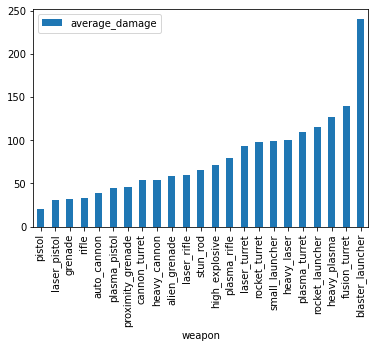

In [11]:
average_damage.plot.bar()

### Shots Per Turn

Supposing all the attacks are done on auto, or the highest rate of fire setting.

In [12]:
shots_per_turn = weapon_attacks[["weapon", "turn_max_shots"]]
shots_per_turn = shots_per_turn.rename(columns={"turn_max_shots": "turn_shots"})
shots_per_turn = shots_per_turn.groupby("weapon").max()
shots_per_turn = shots_per_turn.sort_values(by=["turn_shots"])
shots_per_turn

,turn_shots
weapon,
blaster_launcher,1.204819
alien_grenade,1.269841
grenade,1.269841
high_explosive,1.269841
proximity_grenade,1.269841
fusion_turret,1.515152
rocket_launcher,1.877934
small_launcher,2.040816
rocket_turret,2.222222


<AxesSubplot:xlabel='weapon'>

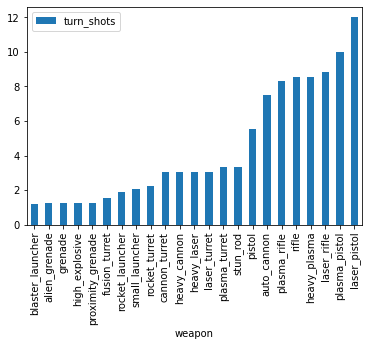

In [13]:
shots_per_turn.plot.bar()

### Ammo

In [14]:
weapon_ammo = weapon_attacks[["weapon", "capacity"]]
weapon_ammo = weapon_ammo.rename(columns={"capacity": "ammo"})
weapon_ammo = weapon_ammo.groupby("weapon").max()
weapon_ammo = weapon_ammo.sort_values(by=["ammo"])
weapon_ammo = weapon_ammo[weapon_ammo["ammo"] < 255]
weapon_ammo

,ammo
weapon,
alien_grenade,1.0
rocket_launcher,1.0
proximity_grenade,1.0
high_explosive,1.0
grenade,1.0
small_launcher,1.0
blaster_launcher,1.0
heavy_cannon,6.0
rocket_turret,8.0


<AxesSubplot:xlabel='weapon'>

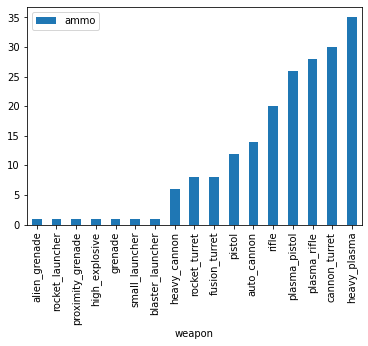

In [15]:
weapon_ammo.plot.bar()

## Damage Ranking

### Most Damaging Weapon

In a single turn, shooting as much as possible, which weapon does the most damage.

This takes into account reloading.

In [16]:
most_damaging_weapon = weapon_attacks[["weapon", "turn_damage_expected"]]
most_damaging_weapon = most_damaging_weapon.rename(columns={"turn_damage_expected": "turn_damage"})
most_damaging_weapon = most_damaging_weapon.groupby("weapon").max()
most_damaging_weapon = most_damaging_weapon.sort_values(by=["turn_damage"])
most_damaging_weapon

,turn_damage
weapon,
grenade,41.269841
proximity_grenade,57.777778
alien_grenade,74.285714
pistol,86.666667
rifle,90.000000
high_explosive,90.793651
cannon_turret,109.090909
heavy_cannon,109.090909
auto_cannon,115.200000


<AxesSubplot:xlabel='weapon'>

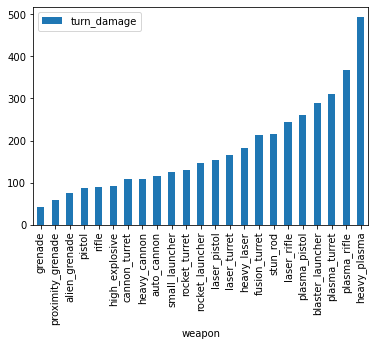

In [17]:
most_damaging_weapon.plot.bar()

### Most Damaging Snapshot

In [18]:
most_damaging_weapon_snap = weapon_attacks[weapon_attacks["fire_mode"] == "snapshot"]
most_damaging_weapon_snap = most_damaging_weapon_snap[["weapon", "turn_damage_expected"]]
most_damaging_weapon_snap = most_damaging_weapon_snap.rename(columns={"turn_damage_expected": "turn_damage"})
most_damaging_weapon_snap = most_damaging_weapon_snap.groupby("weapon").max()
most_damaging_weapon_snap = most_damaging_weapon_snap.sort_values(by=["turn_damage"])
most_damaging_weapon_snap

,turn_damage
weapon,
rifle,72.000000
auto_cannon,81.454545
pistol,86.666667
laser_pistol,92.000000
rocket_launcher,103.286385
rocket_turret,103.888889
cannon_turret,109.090909
heavy_cannon,109.090909
plasma_pistol,112.666667


<AxesSubplot:xlabel='weapon'>

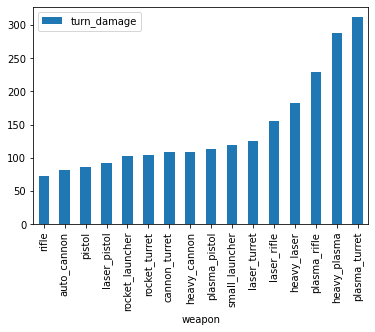

In [19]:
most_damaging_weapon_snap.plot.bar()

### Most Damaging Aimed

In [20]:
most_damaging_weapon_aim = weapon_attacks[weapon_attacks["fire_mode"] == "aimed"]
most_damaging_weapon_aim = most_damaging_weapon_aim[["weapon", "turn_damage_expected"]]
most_damaging_weapon_aim = most_damaging_weapon_aim.rename(columns={"turn_damage_expected": "turn_damage"})
most_damaging_weapon_aim = most_damaging_weapon_aim.groupby("weapon").max()
most_damaging_weapon_aim = most_damaging_weapon_aim.sort_values(by=["turn_damage"])
most_damaging_weapon_aim

,turn_damage
weapon,
rifle,41.250000
auto_cannon,49.200000
laser_pistol,56.872727
cannon_turret,67.500000
heavy_cannon,67.500000
pistol,67.600000
plasma_pistol,73.666667
laser_rifle,120.000000
small_launcher,125.714286


<AxesSubplot:xlabel='weapon'>

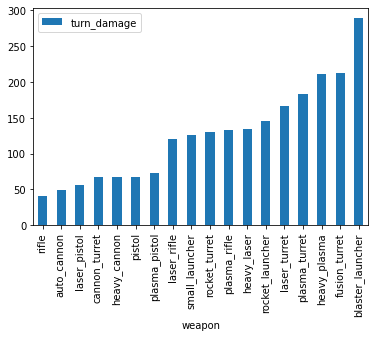

In [21]:
most_damaging_weapon_aim.plot.bar()

### Most Damaging Auto

In [22]:
most_damaging_weapon_auto = weapon_attacks[weapon_attacks["fire_mode"] == "auto"]
most_damaging_weapon_auto = most_damaging_weapon_auto[["weapon", "turn_damage_expected"]]
most_damaging_weapon_auto = most_damaging_weapon_auto.rename(columns={"turn_damage_expected": "turn_damage"})
most_damaging_weapon_auto = most_damaging_weapon_auto.groupby("weapon").max()
most_damaging_weapon_auto = most_damaging_weapon_auto.sort_values(by=["turn_damage"])
most_damaging_weapon_auto

,turn_damage
weapon,
rifle,90.000000
auto_cannon,115.200000
laser_pistol,154.560000
laser_rifle,243.529412
plasma_pistol,260.000000
plasma_rifle,366.666667
heavy_plasma,492.857143


<AxesSubplot:xlabel='weapon'>

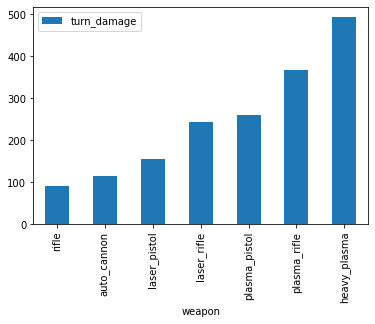

In [23]:
most_damaging_weapon_auto.plot.bar()

### Most Damaging Grenade

In [24]:
most_damaging_weapon_grenade = weapon_attacks[weapon_attacks["fire_mode"] == "grenade"]
most_damaging_weapon_grenade = most_damaging_weapon_grenade[["weapon", "turn_damage_expected"]]
most_damaging_weapon_grenade = most_damaging_weapon_grenade.rename(columns={"turn_damage_expected": "turn_damage"})
most_damaging_weapon_grenade = most_damaging_weapon_grenade.set_index(["weapon"])
most_damaging_weapon_grenade = most_damaging_weapon_grenade.sort_values(by=["turn_damage"])
most_damaging_weapon_grenade

,turn_damage
weapon,
grenade,41.269841
proximity_grenade,57.777778
alien_grenade,74.285714
high_explosive,90.793651


<AxesSubplot:xlabel='weapon'>

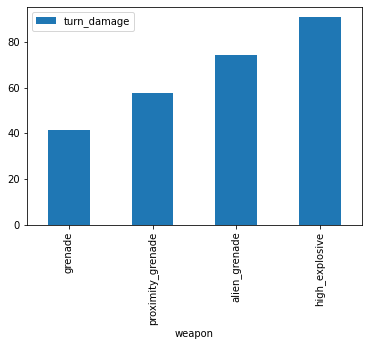

In [25]:
most_damaging_weapon_grenade.plot.bar()

## Damage to Target Type

### Data Merge

In [26]:
weapon_damages = weapon_attacks
weapon_damages = weapon_damages.append([weapon_damages] * (len(damage_modifiers.index)-1),ignore_index=True)
weapon_damages["key"] = weapon_damages.groupby(["weapon", "ammo", "fire_mode"]).cumcount()

targets = damage_modifiers["target"]

weapon_damages = pd.merge(weapon_damages, targets, left_on="key", right_index=True, how="left", sort=False)
weapon_damages = weapon_damages.drop(columns=["key"])
weapon_damages

,weapon,grip,ammo,damage,damage_type,capacity,fire_mode,time_units,accuracy,burst,average_damage,clip_damage,turn_max_shots,turns_to_reload,turn_damage_max,turn_damage_expected,target
0,alien_grenade,1,alien_grenade,90,high_explosive,1.0,grenade,75,65,1,58.50,90.0,1.269841,0.787500,114.285714,74.285714,terrain
1,auto_cannon,2,auto_cannon_ap,42,armor_piercing,14.0,aimed,80,82,1,34.44,588.0,1.250000,11.200000,52.500000,43.050000,terrain
2,auto_cannon,2,auto_cannon_he,44,high_explosive,14.0,aimed,80,82,1,36.08,616.0,1.250000,11.200000,55.000000,45.100000,terrain
3,auto_cannon,2,auto_cannon_inc,48,incendiary,14.0,aimed,80,82,1,39.36,672.0,1.250000,11.200000,60.000000,49.200000,terrain
4,auto_cannon,2,auto_cannon_ap,42,armor_piercing,14.0,auto,40,32,3,13.44,588.0,7.500000,1.866667,315.000000,100.800000,terrain
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,rocket_turret,2,hwp_rocket,85,high_explosive,8.0,aimed,75,115,1,97.75,680.0,1.333333,6.000000,113.333333,130.333333,zombie
836,rocket_turret,2,hwp_rocket,85,high_explosive,8.0,snapshot,45,55,1,46.75,680.0,2.222222,3.600000,188.888889,103.888889,zombie
837,small_launcher,2,stun_bomb,90,stun,1.0,aimed,75,110,1,99.00,90.0,1.269841,0.787500,114.285714,125.714286,zombie
838,small_launcher,2,stun_bomb,90,stun,1.0,snapshot,40,65,1,58.50,90.0,2.040816,0.490000,183.673469,119.387755,zombie


### Damage vs Type

In [27]:
def damage_modifier(group):
    target = damage_modifiers[damage_modifiers["target"] == group["target"]]
    damage = target[group["damage_type"]].values[0]
    return damage / 100

In [28]:
weapon_damages["target_damage"] = weapon_damages.apply(damage_modifier, axis=1)
weapon_damages["target_damage"] = weapon_damages.apply(lambda x: x["damage"] * damage_modifier(x), axis=1)
weapon_damages["target_average_damage"] = weapon_damages.apply(lambda x: x["average_damage"] * damage_modifier(x), axis=1)
weapon_damages["target_clip_damage"] = weapon_damages.apply(lambda x: x["clip_damage"] * damage_modifier(x), axis=1)
weapon_damages["target_turn_damage_max"] = weapon_damages.apply(lambda x: x["turn_damage_max"] * damage_modifier(x), axis=1)
weapon_damages["target_turn_damage_expected"] = weapon_damages.apply(lambda x: x["turn_damage_expected"] * damage_modifier(x), axis=1)
weapon_damages

,weapon,grip,ammo,damage,damage_type,capacity,fire_mode,time_units,accuracy,burst,...,turn_max_shots,turns_to_reload,turn_damage_max,turn_damage_expected,target,target_damage,target_average_damage,target_clip_damage,target_turn_damage_max,target_turn_damage_expected
0,alien_grenade,1,alien_grenade,90,high_explosive,1.0,grenade,75,65,1,...,1.269841,0.787500,114.285714,74.285714,terrain,90.0,58.50,90.0,114.285714,74.285714
1,auto_cannon,2,auto_cannon_ap,42,armor_piercing,14.0,aimed,80,82,1,...,1.250000,11.200000,52.500000,43.050000,terrain,42.0,34.44,588.0,52.500000,43.050000
2,auto_cannon,2,auto_cannon_he,44,high_explosive,14.0,aimed,80,82,1,...,1.250000,11.200000,55.000000,45.100000,terrain,44.0,36.08,616.0,55.000000,45.100000
3,auto_cannon,2,auto_cannon_inc,48,incendiary,14.0,aimed,80,82,1,...,1.250000,11.200000,60.000000,49.200000,terrain,48.0,39.36,672.0,60.000000,49.200000
4,auto_cannon,2,auto_cannon_ap,42,armor_piercing,14.0,auto,40,32,3,...,7.500000,1.866667,315.000000,100.800000,terrain,42.0,13.44,588.0,315.000000,100.800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,rocket_turret,2,hwp_rocket,85,high_explosive,8.0,aimed,75,115,1,...,1.333333,6.000000,113.333333,130.333333,zombie,68.0,78.20,544.0,90.666667,104.266667
836,rocket_turret,2,hwp_rocket,85,high_explosive,8.0,snapshot,45,55,1,...,2.222222,3.600000,188.888889,103.888889,zombie,68.0,37.40,544.0,151.111111,83.111111
837,small_launcher,2,stun_bomb,90,stun,1.0,aimed,75,110,1,...,1.269841,0.787500,114.285714,125.714286,zombie,0.0,0.00,0.0,0.000000,0.000000
838,small_launcher,2,stun_bomb,90,stun,1.0,snapshot,40,65,1,...,2.040816,0.490000,183.673469,119.387755,zombie,0.0,0.00,0.0,0.000000,0.000000


## Weapon Damages by Target

In [29]:
# weapon_damages_targets = weapon_damages[weapon_damages["weapon"] == "pistol"]
weapon_damages_targets = weapon_damages
weapon_damages_targets = weapon_damages_targets.groupby(["weapon", "target"]).max()
weapon_damages_targets = weapon_damages_targets[["target_turn_damage_expected"]]
weapon_damages_targets = weapon_damages_targets.rename(columns={"target_turn_damage_expected": "turn_damage"})
weapon_damages_targets = weapon_damages_targets.sort_values(by=["turn_damage"])
weapon_damages_targets

turn_damage
weapon         target                 
stun_rod       zombie         0.000000
small_launcher zombie         0.000000
grenade        cyberdisk     24.761905
               tank          30.952381
               zombie        33.015873
...                                ...
heavy_plasma   ethereal     492.857143
               cyberdisk    492.857143
               chryssalid   492.857143
               terrain      492.857143
               tank         492.857143

[322 rows x 1 columns]

### Weapon Target Damage List

<AxesSubplot:xlabel='target'>

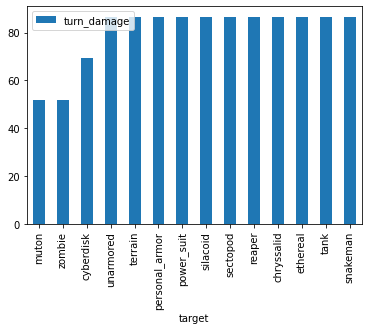

In [30]:
weapon_damages_targets.loc[ "pistol" , : ].plot.bar()

<AxesSubplot:xlabel='target'>

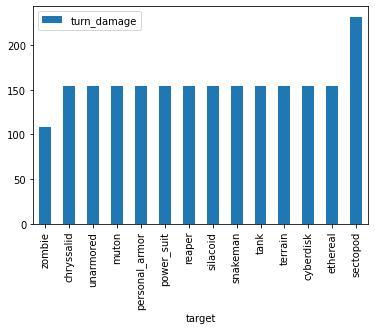

In [31]:
weapon_damages_targets.loc[ "laser_pistol" , : ].plot.bar()

### Target Damage Lists

#### Averages

In [68]:
weapon_damages_averages = weapon_damages_targets.groupby(["weapon"]).mean()
weapon_damages_averages = weapon_damages_averages.sort_values(by=["turn_damage"])
weapon_damages_averages

,turn_damage
weapon,
grenade,39.058957
proximity_grenade,54.682540
alien_grenade,70.306122
pistol,80.476190
rifle,83.571429
high_explosive,85.929705
cannon_turret,101.298701
small_launcher,111.346939
heavy_cannon,112.415584


<AxesSubplot:xlabel='weapon'>

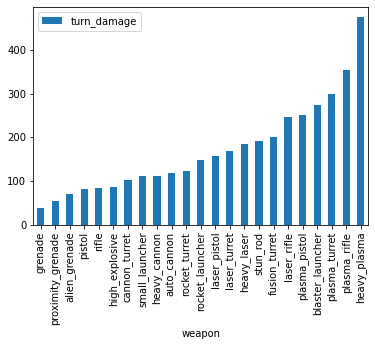

In [66]:
weapon_damages_averages.plot.bar()

#### Terrain

In [32]:
weapon_damages_terrain = weapon_damages_targets.xs("terrain", level="target")
weapon_damages_terrain = weapon_damages_terrain.sort_values(by=["turn_damage"])

<AxesSubplot:xlabel='weapon'>

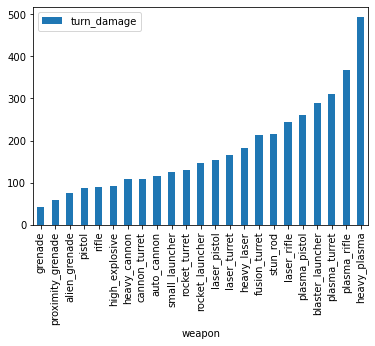

In [33]:
weapon_damages_terrain.plot.bar()

#### Unarmored

In [34]:
weapon_damages_unarmored = weapon_damages_targets.xs("unarmored", level="target")
weapon_damages_unarmored = weapon_damages_unarmored.sort_values(by=["turn_damage"])

<AxesSubplot:xlabel='weapon'>

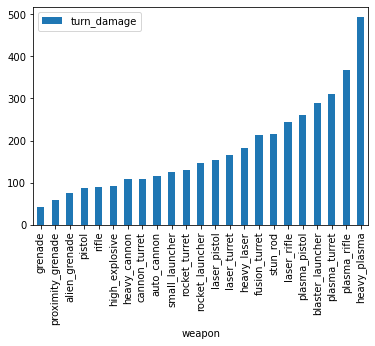

In [35]:
weapon_damages_unarmored.plot.bar()

#### Personal Armor

In [36]:
weapon_damages_armor = weapon_damages_targets.xs("personal_armor", level="target")
weapon_damages_armor = weapon_damages_armor.sort_values(by=["turn_damage"])

<AxesSubplot:xlabel='weapon'>

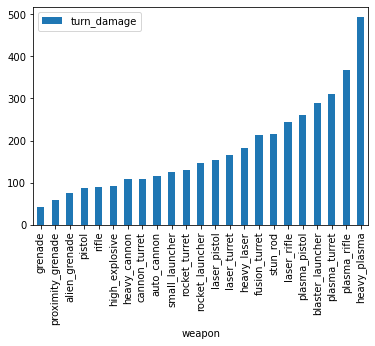

In [37]:
weapon_damages_unarmored.plot.bar()

#### Power Suit

In [38]:
weapon_damages_power_suit = weapon_damages_targets.xs("power_suit", level="target")
weapon_damages_power_suit = weapon_damages_power_suit.sort_values(by=["turn_damage"])

<AxesSubplot:xlabel='weapon'>

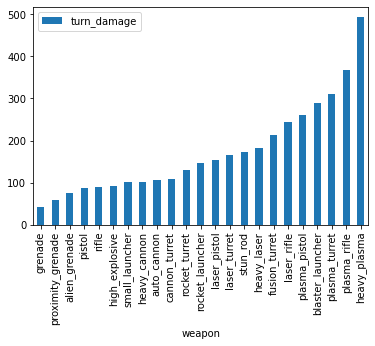

In [39]:
weapon_damages_power_suit.plot.bar()

#### Tank

In [40]:
weapon_damages_tank = weapon_damages_targets.xs("tank", level="target")
weapon_damages_tank = weapon_damages_tank.sort_values(by=["turn_damage"])

<AxesSubplot:xlabel='weapon'>

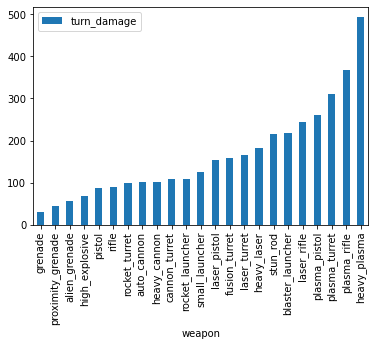

In [41]:
weapon_damages_tank.plot.bar()

#### Snakeman

In [42]:
weapon_damages_snakeman = weapon_damages_targets.xs("snakeman", level="target")
weapon_damages_snakeman = weapon_damages_snakeman.sort_values(by=["turn_damage"])

<AxesSubplot:xlabel='weapon'>

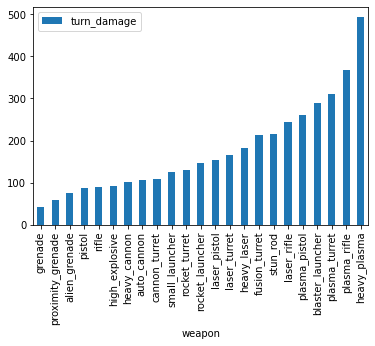

In [43]:
weapon_damages_snakeman.plot.bar()

#### Ethereal

In [44]:
weapon_damages_ethereal = weapon_damages_targets.xs("ethereal", level="target")
weapon_damages_ethereal = weapon_damages_ethereal.sort_values(by=["turn_damage"])

<AxesSubplot:xlabel='weapon'>

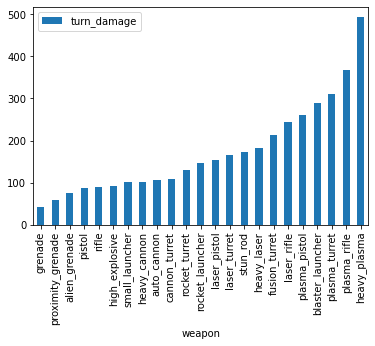

In [45]:
weapon_damages_ethereal.plot.bar()

#### Muton

In [46]:
weapon_damages_muton = weapon_damages_targets.xs("muton", level="target")
weapon_damages_muton = weapon_damages_muton.sort_values(by=["turn_damage"])

<AxesSubplot:xlabel='weapon'>

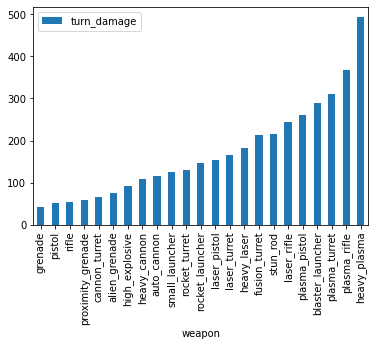

In [47]:
weapon_damages_muton.plot.bar()

#### Silacoid

In [48]:
weapon_damages_silacoid = weapon_damages_targets.xs("silacoid", level="target")
weapon_damages_silacoid = weapon_damages_silacoid.sort_values(by=["turn_damage"])

<AxesSubplot:xlabel='weapon'>

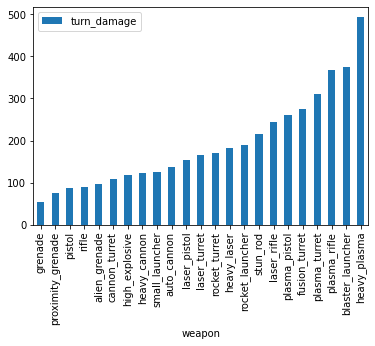

In [49]:
weapon_damages_silacoid.plot.bar()

#### Chryssalid

In [50]:
weapon_damages_chryssalid = weapon_damages_targets.xs("chryssalid", level="target")
weapon_damages_chryssalid = weapon_damages_chryssalid.sort_values(by=["turn_damage"])

<AxesSubplot:xlabel='weapon'>

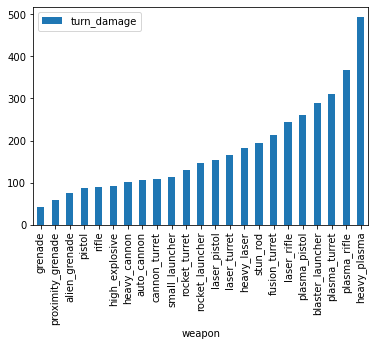

In [51]:
weapon_damages_chryssalid.plot.bar()

#### Reaper

In [52]:
weapon_damages_reaper = weapon_damages_targets.xs("reaper", level="target")
weapon_damages_reaper = weapon_damages_reaper.sort_values(by=["turn_damage"])

<AxesSubplot:xlabel='weapon'>

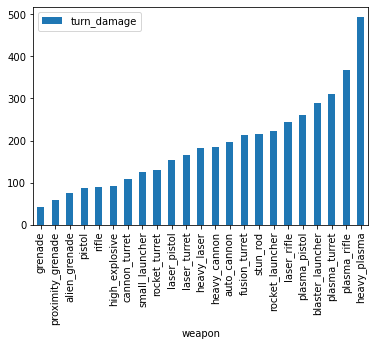

In [53]:
weapon_damages_reaper.plot.bar()

#### Sectopod

In [54]:
weapon_damages_sectopod = weapon_damages_targets.xs("sectopod", level="target")
weapon_damages_sectopod = weapon_damages_sectopod.sort_values(by=["turn_damage"])

<AxesSubplot:xlabel='weapon'>

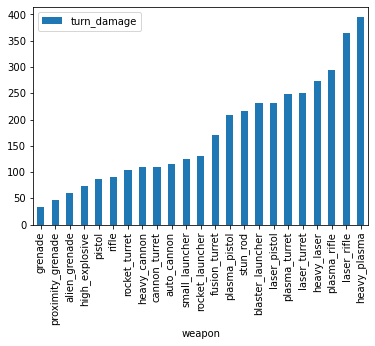

In [55]:
weapon_damages_sectopod.plot.bar()

#### Cyberdisk

In [56]:
weapon_damages_cyberdisk = weapon_damages_targets.xs("cyberdisk", level="target")
weapon_damages_cyberdisk = weapon_damages_cyberdisk.sort_values(by=["turn_damage"])

<AxesSubplot:xlabel='weapon'>

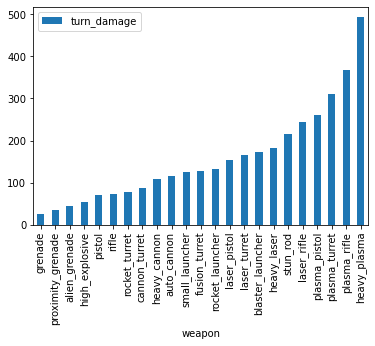

In [57]:
weapon_damages_cyberdisk.plot.bar()

#### Zombie

In [58]:
weapon_damages_zombie = weapon_damages_targets.xs("zombie", level="target")
weapon_damages_zombie = weapon_damages_zombie.sort_values(by=["turn_damage"])

<AxesSubplot:xlabel='weapon'>

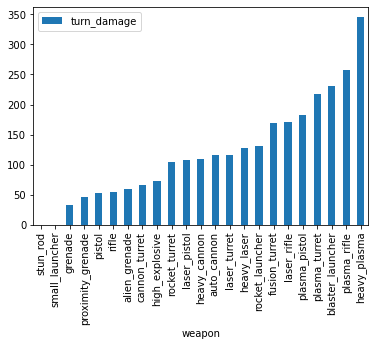

In [59]:
weapon_damages_zombie.plot.bar()